In [16]:
import random
import numpy as np
import torch

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # 如果使用多个 GPU，设置以下参数
    torch.cuda.manual_seed_all(seed)
    # 确保 cudnn 的确定性，可能会降低性能
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 在代码开头设置随机数种子
set_random_seed(42)


Files already downloaded and verified
Saved real images grid to cifar100_real_grid.png
Attempt 1/10
Attempt 1: Inception Score = 2.9301 ± 0.3530
New best IS found: 2.9301
Attempt 2/10
Attempt 2: Inception Score = 2.8624 ± 0.2367
Attempt 3/10
Attempt 3: Inception Score = 2.9145 ± 0.2602
Attempt 4/10
Attempt 4: Inception Score = 3.1986 ± 0.6339
New best IS found: 3.1986
Attempt 5/10
Attempt 5: Inception Score = 3.0327 ± 0.4365
Attempt 6/10
Attempt 6: Inception Score = 3.2057 ± 0.5522
New best IS found: 3.2057
Attempt 7/10
Attempt 7: Inception Score = 3.0609 ± 0.3735
Attempt 8/10
Attempt 8: Inception Score = 2.9506 ± 0.5176
Attempt 9/10
Attempt 9: Inception Score = 3.0602 ± 0.4032
Attempt 10/10
Attempt 10: Inception Score = 3.0090 ± 0.3667
Saved best generated images grid to cifar100_generated_best_grid.png
Best Inception Score: 3.2057


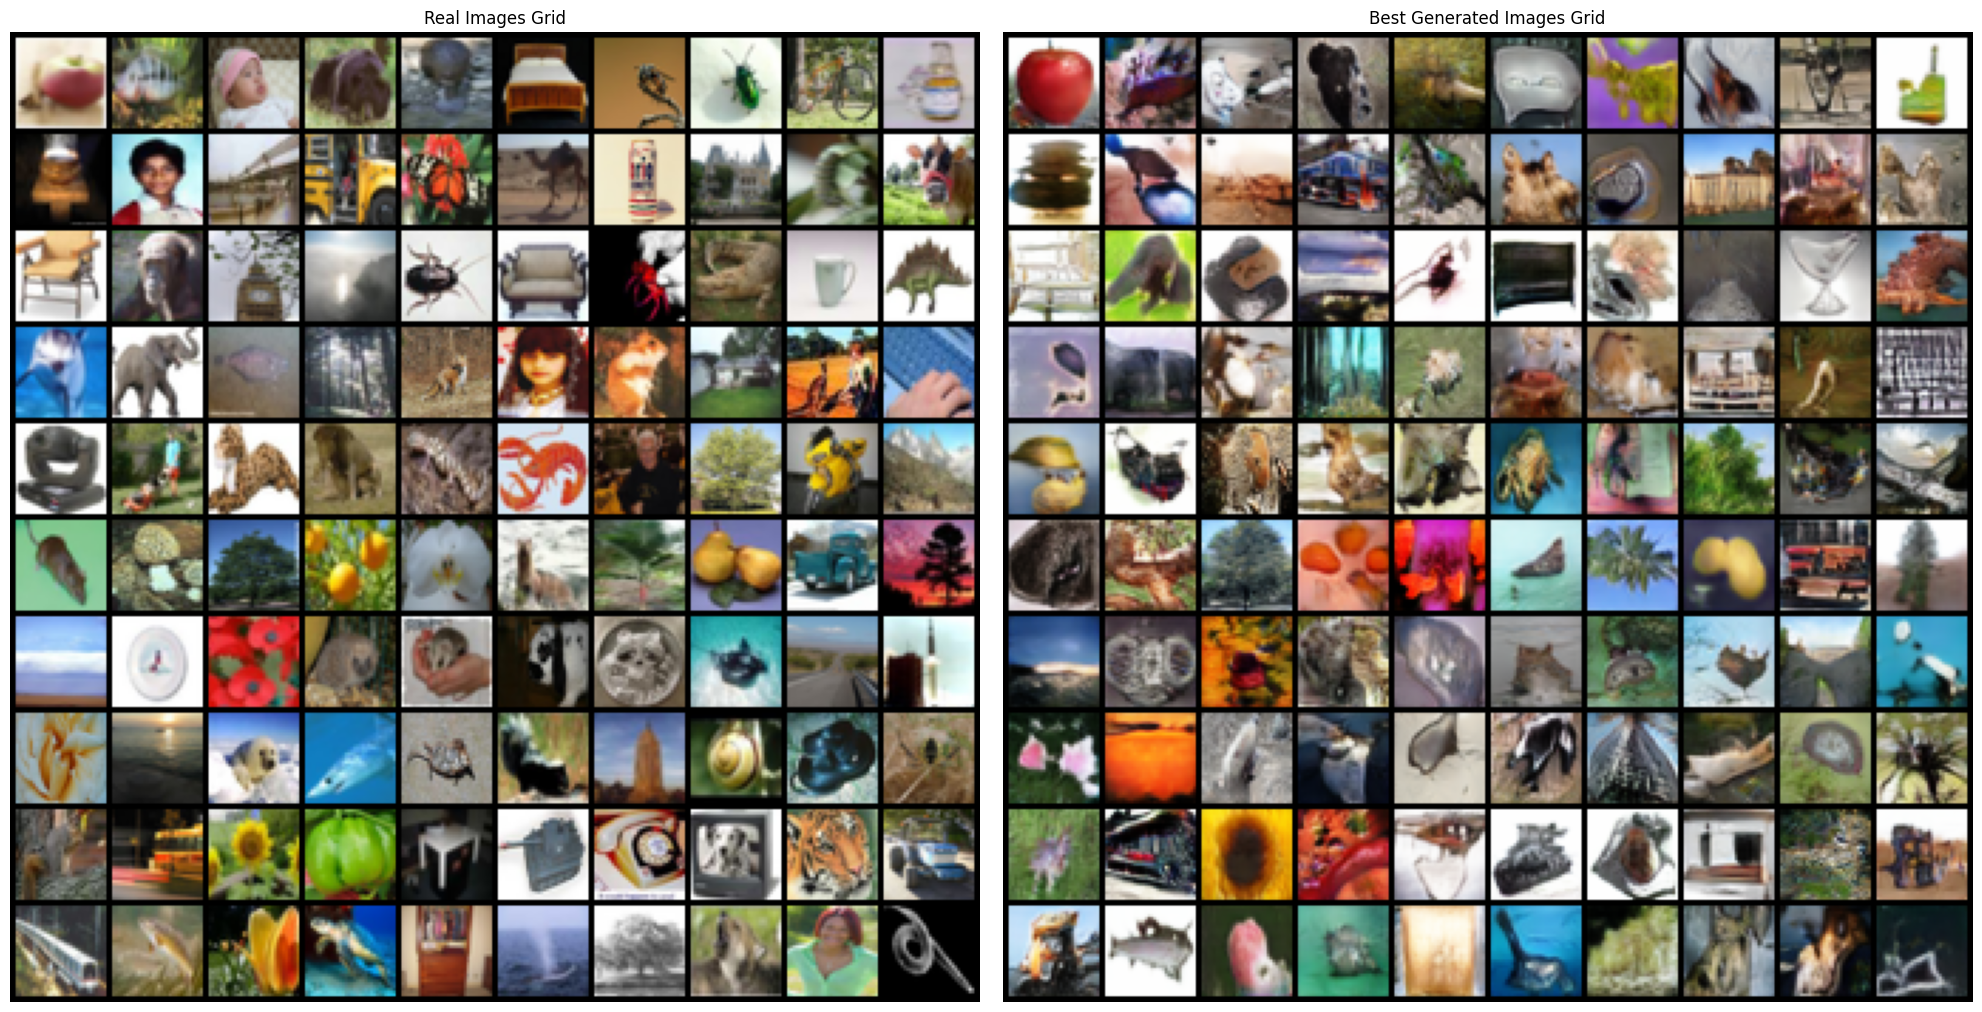

In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import inception_v3
from torch.utils.data import DataLoader

# ------------------------------
# Define Generator Dependencies
# ------------------------------

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.channel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim,      kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, width, height = x.size()

        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)  # B, HW, C'
        proj_key   = self.key_conv(x).view(m_batchsize, -1, width * height)                      # B, C', HW
        energy     = torch.bmm(proj_query, proj_key)                                             # B, HW, HW
        attention  = self.softmax(energy)                                                       # B, HW, HW

        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)                    # B, C, HW

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))                                 # B, C, HW
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma * out + x
        return out

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConditionalBatchNorm2d, self).__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        # Initialize gamma to 1 and beta to 0
        self.embed.weight.data[:, :num_features].fill_(1)
        self.embed.weight.data[:, num_features:].zero_()

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta  = beta.unsqueeze(2).unsqueeze(3)
        out = gamma * out + beta
        return out

class ResBlockG(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(ResBlockG, self).__init__()
        self.bn1 = ConditionalBatchNorm2d(in_channels, num_classes)
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.bn2 = ConditionalBatchNorm2d(out_channels, num_classes)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels or True:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x, labels):
        out = self.bn1(x, labels)
        out = self.activation(out)
        out = self.conv1(out)
        out = self.bn2(out, labels)
        out = self.activation(out)
        out = self.conv2(out)
        shortcut = self.shortcut(x)
        out += shortcut
        return out

class CrossAttention(nn.Module):
    def __init__(self, in_dim):
        super(CrossAttention, self).__init__()
        # Map image features to Q
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, 1)
        # Map class embedding to K and V
        self.key_linear = nn.Linear(in_dim, in_dim // 8)
        self.value_linear = nn.Linear(in_dim, in_dim)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, class_emb):
        # x: B,C,H,W
        # class_emb: B,C (C same as x's C)
        B, C, H, W = x.size()
        Q = self.query_conv(x).view(B, -1, H*W).permute(0,2,1) # B, HW, C'
        K = self.key_linear(class_emb).unsqueeze(1) # B,1,C'
        # Compute attention weights
        energy = torch.bmm(Q, K.transpose(1,2)) # B, HW, 1
        attention = self.softmax(energy)
        V = self.value_linear(class_emb).unsqueeze(1) # B,1,C
        out = torch.bmm(attention, V) # B, HW, C
        out = out.permute(0,2,1).view(B, C, H, W)
        out = self.gamma * out + x
        return out

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, channels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        img_size = 32  # Fixed image size

        self.init_size = img_size // 16  # init_size = 2
        self.l1 = nn.Linear(latent_dim, 512 * self.init_size ** 2)

        self.res_blocks = nn.ModuleList([
            ResBlockG(512, 512, num_classes),
            ResBlockG(512, 256, num_classes),
            ResBlockG(256, 128, num_classes),
            ResBlockG(128, 64, num_classes)
        ])

        self.attention = SelfAttention(64)

        # Class embedding for cross attention (matching 64 channels)
        self.class_embed_ca = nn.Embedding(num_classes, 64)
        self.cross_attention = CrossAttention(64)

        # Feature fusion convolution layer (upsample intermediate layer and fuse with final features)
        self.fusion_conv = nn.Conv2d(256+64, 64, 1, 1, 0)

        self.bn = ConditionalBatchNorm2d(64, num_classes)
        self.activation = nn.ReLU(inplace=True)
        self.conv_out = nn.Conv2d(64, channels, 3, 1, 1)

    def forward(self, noise, labels):
        out = self.l1(noise)
        out = out.view(out.size(0), 512, self.init_size, self.init_size)

        # Multi-level feature generation
        out1 = self.res_blocks[0](out, labels)   # 512 channels, size 4x4
        out2 = self.res_blocks[1](out1, labels)  # 256 channels, size 8x8
        out3 = self.res_blocks[2](out2, labels)  # 128 channels, size 16x16
        out4 = self.res_blocks[3](out3, labels)  # 64 channels, size 32x32
        out = out4

        # Self-attention
        out = self.attention(out)

        # Cross-attention with class features
        class_emb = self.class_embed_ca(labels)  # B,64
        out = self.cross_attention(out, class_emb)

        # Feature fusion (upsample out2 to out's size, concatenate)
        # out2 is 8x8, out is 32x32
        out2_upsampled = F.interpolate(out2, size=out.shape[2:], mode='nearest') 
        fused = torch.cat([out2_upsampled, out], dim=1) # B,(256+64),32,32
        out = self.fusion_conv(fused) # B,64,32,32

        out = self.bn(out, labels)
        out = self.activation(out)
        img = torch.tanh(self.conv_out(out))
        return img

# ------------------------------
# Define Inception Score Calculation Function
# ------------------------------

def load_inception_net():
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model = WrapInception(inception_model.eval()).to('cuda' if torch.cuda.is_available() else 'cpu')
    return inception_model

class WrapInception(nn.Module):
    def __init__(self, net):
        super(WrapInception, self).__init__()
        self.net = net
        self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1),
                      requires_grad=False)
        self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1),
                     requires_grad=False)
    def forward(self, x):
        # Normalize x
        x = (x + 1.) / 2.0
        x = (x - self.mean) / self.std
        # Upsample if necessary
        if x.shape[2] != 299 or x.shape[3] != 299:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)
        # Forward pass through Inception model layers
        x = self.net.Conv2d_1a_3x3(x)
        x = self.net.Conv2d_2a_3x3(x)
        x = self.net.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.net.Conv2d_3b_1x1(x)
        x = self.net.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.net.Mixed_5b(x)
        x = self.net.Mixed_5c(x)
        x = self.net.Mixed_5d(x)
        x = self.net.Mixed_6a(x)
        x = self.net.Mixed_6b(x)
        x = self.net.Mixed_6c(x)
        x = self.net.Mixed_6d(x)
        x = self.net.Mixed_6e(x)
        x = self.net.Mixed_7a(x)
        x = self.net.Mixed_7b(x)
        x = self.net.Mixed_7c(x)
        pool = torch.mean(x.view(x.size(0), x.size(1), -1), 2)
        logits = self.net.fc(F.dropout(pool, training=False).view(pool.size(0), -1))
        return pool, logits

def calculate_inception_score(images, inception_model, device, batch_size=32, splits=10):
    """
    Calculate the Inception Score (IS).

    Args:
        images (torch.Tensor): Generated images, range [0,1]
        inception_model (nn.Module): Wrapped Inception v3 model
        device (torch.device): Device to perform computation
        batch_size (int): Batch size for processing
        splits (int): Number of splits for IS calculation

    Returns:
        mean (float): Mean IS
        std (float): Standard deviation of IS
    """
    inception_model.eval()
    preds = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(device)
            pool, logits = inception_model(batch)
            # Use logits for probability distribution
            pred = F.softmax(logits, dim=1)
            preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)
        scores = part * (np.log(part + 1e-6) - np.log(py + 1e-6))
        kl = np.mean(np.sum(scores, axis=1))
        split_scores.append(np.exp(kl))

    return np.mean(split_scores), np.std(split_scores)

# ------------------------------
# Main Function
# ------------------------------

def generate_best_cifar100_images(model_path, num_attempts=10, output_real_path='cifar100_real_grid.png', output_generated_path='cifar100_generated_best_grid.png'):
    """
    Generate CIFAR-100 images multiple times, calculate IS for each set, and save the set with the highest IS.

    Args:
        model_path (str): Path to the trained generator model (two_model.pth).
        num_attempts (int): Number of generation attempts.
        output_real_path (str): Path to save the real images grid.
        output_generated_path (str): Path to save the best generated images grid.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Hyperparameters (should match the training script)
    latent_dim = 128
    num_classes = 100
    channels = 3
    img_size = 32

    # Data preprocessing (should match training)
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*channels, [0.5]*channels),
    ])

    # Load CIFAR-100 training set
    train_dataset = datasets.CIFAR100(root='data', train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)

    # Get class names
    class_names = train_dataset.classes  # List of 100 class names

    # Select one real image per class
    real_images = [None] * num_classes  # Initialize list
    for img, label in train_loader:
        for i in range(img.size(0)):
            lbl = label[i].item()
            if real_images[lbl] is None:
                real_images[lbl] = img[i]
            if all([img is not None for img in real_images]):
                break
        if all([img is not None for img in real_images]):
            break

    # Check if all classes have images
    for idx, img in enumerate(real_images):
        if img is None:
            raise ValueError(f"Category {idx} ({class_names[idx]}) does not have a corresponding real image.")

    # Initialize generator and load weights
    generator = Generator(latent_dim, num_classes, channels).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'generator_state_dict' in checkpoint:
        generator.load_state_dict(checkpoint['generator_state_dict'])
    else:
        generator.load_state_dict(checkpoint)
    generator.eval()

    # Load wrapped Inception v3 model
    inception_model = load_inception_net()
    inception_model.to(device)
    inception_model.eval()

    # Prepare real images
    # Denormalize real images to [0,1]
    real_images_denorm = [(img * 0.5 + 0.5).clamp(0, 1) for img in real_images]
    real_images_denorm = torch.stack(real_images_denorm)  # Shape: [100, 3, 32, 32]

    # Create and save real images grid
    real_grid = vutils.make_grid(real_images_denorm, nrow=10, padding=2)
    vutils.save_image(real_grid, output_real_path)
    print(f"Saved real images grid to {output_real_path}")

    best_is = -np.inf
    best_generated_images_denorm = None

    for attempt in range(1, num_attempts + 1):
        print(f"Attempt {attempt}/{num_attempts}")
        generated_images = []
        with torch.no_grad():
            for class_label in range(num_classes):
                z = torch.randn(1, latent_dim, device=device)
                labels = torch.tensor([class_label], device=device)
                gen_img = generator(z, labels)  # Output range [-1, 1]
                generated_images.append(gen_img.cpu())

        # Prepare generated images
        # Denormalize generated images to [0,1]
        generated_images_denorm = [(img.squeeze(0) * 0.5 + 0.5).clamp(0, 1) for img in generated_images]
        generated_images_denorm = torch.stack(generated_images_denorm)  # Shape: [100, 3, 32, 32]

        # Calculate Inception Score
        mean_is, std_is = calculate_inception_score(generated_images_denorm, inception_model, device, batch_size=32, splits=10)
        print(f"Attempt {attempt}: Inception Score = {mean_is:.4f} ± {std_is:.4f}")

        # Update best IS and corresponding generated images
        if mean_is > best_is:
            best_is = mean_is
            best_generated_images_denorm = generated_images_denorm.clone()
            print(f"New best IS found: {best_is:.4f}")

    if best_generated_images_denorm is not None:
        # Create and save best generated images grid
        generated_grid = vutils.make_grid(best_generated_images_denorm, nrow=10, padding=2)
        vutils.save_image(generated_grid, output_generated_path)
        print(f"Saved best generated images grid to {output_generated_path}")
        print(f"Best Inception Score: {best_is:.4f}")
    else:
        print("No generated images were saved.")

    # Optional: Display real images grid and best generated images grid
    real_grid_np = real_grid.permute(1, 2, 0).numpy()
    if best_generated_images_denorm is not None:
        generated_grid_np = generated_grid.permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(real_grid_np)
    axs[0].set_title('Real Images Grid')
    axs[0].axis('off')

    if best_generated_images_denorm is not None:
        axs[1].imshow(generated_grid_np)
        axs[1].set_title('Best Generated Images Grid')
        axs[1].axis('off')
    else:
        axs[1].text(0.5, 0.5, 'No Generated Images', horizontalalignment='center', verticalalignment='center', fontsize=20)
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Path to the saved generator model
    model_save_path = 'two_model.pth'  # Ensure this file exists and the path is correct

    # Output paths
    output_real_grid_path = 'cifar100_real_grid.png'
    output_generated_best_grid_path = 'cifar100_generated_best_grid.png'

    # Generate and save real and best generated images grids
    generate_best_cifar100_images(model_save_path, num_attempts=10, output_real_path=output_real_grid_path, output_generated_path=output_generated_best_grid_path)
